# Imports

In [ ]:
%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [ ]:
from matplotlib.pyplot import *
%matplotlib inline

In [ ]:
from datetime import date,datetime
from os import path
today = date.today()
now = datetime.now()

In [ ]:
import dill
import numpy as np
from copy import copy
from random import sample
from sklearn.model_selection import train_test_split
from time import time

In [ ]:
from cBc import to_clf
from cBc import ClassicalBayesian
from cBc import ClassicalBayesianFit
from cBc import ToClassifierDef
from cBc import get_clf_functions
from cBc import __test__
from cBc import write_classical_Bayesian_to_hdf5_file
from cBc import read_classical_Bayesian_from_hdf5_file

# Parameters for the Cloud Mask

In [6]:
suffix = "_v%s" % now.strftime("%Y%m%d_%H:%M:%S")

#fn_mc = "/home/gts2/data/aux_data/cld_mask/20160321_s2.dill"
fn_mc = "/home/gts2/data/aux_data/cld_mask/S2_classi_20170413.dill"

fn_out = ("/home/gts2/data/aux_data/cld_mask/cld_mask_" + path.basename(fn_mc)).replace(".dill",suffix + ".h5")

class_names = {'Shadow': 30, 'Clear': 10, 'Snow': 60, 'Water': 20, 'Cirrus': 40, 'Cloud': 50}
class_ids = {v:k for k,v in class_names.items()}
mask_legend = {value:key for key,value in class_names.items()}
band_names = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']
# RGB color coding of classes
clf_to_col = {10: (0.0, 0.39215686274509803, 0.0),
              20: (0.0, 0.0, 0.5019607843137255),
              30: (0.5450980392156862, 0.0, 0.5450980392156862),
              40: (0.5450980392156862, 0.0, 0.0),
              50: (0.27450980392156865, 0.5098039215686274, 0.7058823529411765),
              60: (1.0, 0.5490196078431373, 0.0)}

In [7]:
fn_out

'/home/gts2/data/aux_data/cld_mask/cld_mask_S2_classi_20170413_v20170413_11:19:40.h5'

In [8]:
mk_clf=ToClassifierDef(clf_functions=get_clf_functions(),
        classifiers_id=[(2,), (9, 0), (10, 1), (12,), (1, 8)],
        classifiers_fk=['channel', 'difference', 'index', 'channel', 'index'])
clf_suffix = "_".join([(fk+str(ids)).replace(" ","").replace(",)",")") for fk,ids in zip(mk_clf.classifiers_fk,mk_clf.classifiers_id)])

# Load Data

In [9]:
suffix = fn_mc.split(".dill")[0].split("_")[-1]

with open(fn_mc,"rb") as fl:
    dat = dill.load(fl)
clf_classes,clf_data_arr,clf_metadata = dat

class_map = list(clf_metadata["Class Names"].items())

if suffix == "s2":
    clf_data_arr = np.nan_to_num(np.array(clf_data_arr,dtype=np.float))
del dat
occurences = {class_name:len(clf_classes[clf_classes == class_val]) for class_name,class_val in class_map}
orig_classes = copy(clf_metadata["Class Names"])
clf_metadata["Class Names"] = {name:value for name,value in class_map if occurences[name]>0}

data_norm = []
clf_norm = []
nn_min_class = np.min([len(clf_classes[clf_classes == class_val]) for class_name,class_val in class_map])-1


for class_name,class_val in class_map:    
    #idx = sample(list(np.where(clf_classes == class_val)[0]),nn_min_class)  # same number for all classes
    idx = np.where(clf_classes == class_val)[0]  # use all data
    
    data_norm.append(clf_data_arr[idx])
    clf_norm.append(clf_classes[idx])    
    print(class_name,class_val,nn_min_class,clf_classes[idx].shape)   
    
clf_classes_norm = np.hstack(clf_norm)
clf_data_norm = np.vstack(data_norm)

del clf_classes
del clf_data_arr

clf_data = dict(zip(("XX_train","XX_test","YY_train","YY_test"),
                    train_test_split(clf_data_norm,clf_classes_norm,test_size=0.001,random_state=42)))
clf_data.keys()

sel_test = np.array(sample(range(clf_data["XX_test"].shape[0]),np.min([len(clf_data["YY_test"]),
                                                                       np.min([clf_data["XX_test"].shape[0],5000000])])),dtype=np.int)
sel_train = np.array(sample(range(clf_data["XX_train"].shape[0]),np.min([len(clf_data["YY_train"]),
                                                                         np.min([clf_data["XX_train"].shape[0],5000000])])),dtype=np.int)

dat_test_train = {"xx":to_clf(clf_data["XX_train"][sel_train,:]),"yy":clf_data["YY_train"][sel_train]}
dat_test_test = {"xx":to_clf(clf_data["XX_test"][sel_test,:]),"yy":clf_data["YY_test"][sel_test]}

print(clf_data["XX_train"].shape,clf_data["XX_test"].shape,clf_data["YY_train"].shape,clf_data["YY_test"].shape)

# save data for later use
ds = np.array(np.vstack((clf_data[ds] for ds in ["XX_train","XX_test"])),dtype=np.float16)
np.savez("/home/gts2/notebooks/cld_mask_dev/ds.npz",ds)

Shadow 30 137294 (137295,)
Snow 60 137294 (417414,)
Cirrus 40 137294 (499372,)
Cloud 50 137294 (486430,)
Water 20 137294 (447811,)
Clear 10 137294 (1040411,)
(3025704, 13) (3029, 13) (3025704,) (3029,)


In [10]:
ds_y = np.array(np.hstack((clf_data[ds] for ds in ["YY_train","YY_test"])),dtype=np.float16)
np.savez("/home/gts2/notebooks/cld_mask_dev/ds_y.npz",ds)

# Novelty Detector

## One Class SVM

In [ ]:
from sklearn.svm import OneClassSVM
import Density_Sampling
import pickle
import tables
import numpy as np
from random import sample
from os import path
from time import time
from cBc import ToClassifierDef
from cBc import get_clf_functions
from sklearn.model_selection import GridSearchCV
from random import choice
from operator import itemgetter
import json
from tqdm import tqdm_notebook
from matplotlib.pyplot import *
%matplotlib inline

In [ ]:
dsf = np.load("/home/gts2/notebooks/cld_mask_dev/ds.npz")
ds = dsf.items()[0][1]
# random data dabed on pdf of
ds_rnd = np.abs(np.transpose(np.vstack([np.random.normal(loc=mn,scale=sd,size=4000) for mn,sd in zip(np.mean(np.array(ds,dtype=np.float),axis=0),np.std(np.array(ds,dtype=np.float),axis=0))])))

In [ ]:
figure(figsize=(15,7))
_ = plot(np.transpose(ds[sample(range(ds.shape[0]),1),:]),"g",label="database")
_ = plot(np.transpose(ds[sample(range(ds.shape[0]),6),:]),"g")
_ = plot(np.transpose(ds_rnd[sample(range(ds_rnd.shape[0]),1),:]),"b",label="test spectra")
_ = plot(np.transpose(ds_rnd[sample(range(ds_rnd.shape[0]),6),:]),"b")
xlabel("channel")
ylabel("TOA reflectance")
legend()

In [ ]:
from time import time

In [ ]:
mk_clf = ToClassifierDef(clf_functions=get_clf_functions(),
        classifiers_id=[(2,), (9, 0), (10, 1), (12,), (1, 8)],
        classifiers_fk=['channel', 'difference', 'index', 'channel', 'index'])
clf_suffix = "_".join([(fk+str(ids)).replace(" ","").replace(",)",")") for fk,ids in zip(mk_clf.classifiers_fk,mk_clf.classifiers_id)])
ds_rnd_clf = mk_clf(ds_rnd)
bf_full = mk_clf(np.array(ds[:,:],dtype=np.float32))
print(ds_rnd_clf.shape)
def tst2(nov,X=None,y=None,debug=False):
    if X is None:
        pr = nov.predict(ds[::4000,:])
    else:
        pr = nov.predict(X)
   
    pr_rnd = nov.predict(ds_rnd_clf)
    
    if debug is False:
        return np.sum(pr == 1) / len(pr) - np.sum(pr_rnd == 1) / len(pr_rnd)
    else:
        return np.sum(pr == 1) / len(pr) , np.sum(pr_rnd == 1) / len(pr_rnd)

In [ ]:
results = []

In [ ]:
# loop gridsearch over randomly selected data sample
best_score = -10
for ii in range(3000):  # increase to search longer, e.g. 200

    #n_train = choice([300,500,1000,3000,5000,10000,20000])
    n_train = choice([300,500,1000])
    bf = mk_clf(np.array(ds[sample(range(ds.shape[0]),n_train),:],dtype=np.float32))

    clf = GridSearchCV(OneClassSVM(),param_grid={"kernel":['linear', 'poly', 'rbf'],"coef0":[0.0,0.5,1.0],"tol":[0.001,0.1,0.3,0.5],"nu":[0.0001,0.001,0.005,0.01],"gamma":[0,7,10,15,50]},scoring=tst2)
    clf.fit(X=bf)

    t0 = time()
    score = tst2(clf.best_estimator_,debug=True,X=bf_full)
    t1 = time()
    tt = (t1 - t0) / bf_full.shape[0] * 5000**2 / 60
    
    if clf.best_score_ > best_score:
        best_score = clf.best_score_
        results.append((clf.best_score_,clf,n_train,bf,score,tt))
        print(ii,best_score,clf.best_params_,clf.best_score_,score,n_train,"nv runtime: %.3f min" % tt)
    elif clf.best_score_ > 0.8 and tt<3:
        results.append((clf.best_score_,clf,n_train,bf,score,tt))
        print(ii,"ok result:",best_score,clf.best_params_,clf.best_score_,score,n_train,"nv runtime: %.3f min" % tt)

In [ ]:
len(results)

In [ ]:
best = sorted([res for res in results if res[-1] < 3.0],key=itemgetter(0))[-1]
print(best[0],best[-2],"time:",best[-1])

In [ ]:
best = sorted(results,key=itemgetter(0))[-1]
print(best[0],best[-2])

In [ ]:
print(clf_suffix.replace("(","").replace(")","").replace(",","_"))

In [ ]:
output_path = "/home/gts2/notebooks/cld_mask_dev/"
fn = "novelty_detector_%.2f_%.2f_%s.json" % (best[-2][0],best[-2][1],clf_suffix.replace("(","").replace(")","").replace(",","_"))
out_fn = path.join(output_path,fn)

In [ ]:
print("Write to:%s" % out_fn)
with open(out_fn,"w") as fl:
    json.dump({"params":best[1].best_params_,
               "data":best[3].tolist(),
               "clf":{"id":mk_clf.classifiers_id,
                      "fk":mk_clf.classifiers_fk}
              },fl,indent=2)
print("Read to test:%s" % out_fn)
with open(out_fn,"r") as fl:
    nvc,ncv_clf = (lambda nvc_data:(
        OneClassSVM(**nvc_data["params"]).fit(np.array(nvc_data["data"],dtype=np.float)),
        nvc_data["clf"]
    ))(json.load(fl))
print(ncv_clf)
print("Apply to test data:")
nvc.fit(best[3])
print(tst2(nvc,debug=True,X=bf_full))

## Random Forrest

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [12]:
dsf = np.load("/home/gts2/notebooks/cld_mask_dev/ds.npz")
ds = dsf.items()[0][1]
# random data dabed on pdf of
ds_rnd = np.abs(np.transpose(np.vstack([np.random.normal(loc=1*mn,scale=1*sd,size=400000) for mn,sd in 
                                        zip(np.mean(np.array(ds,dtype=np.float),axis=0),np.std(np.array(ds,dtype=np.float),axis=0))])))

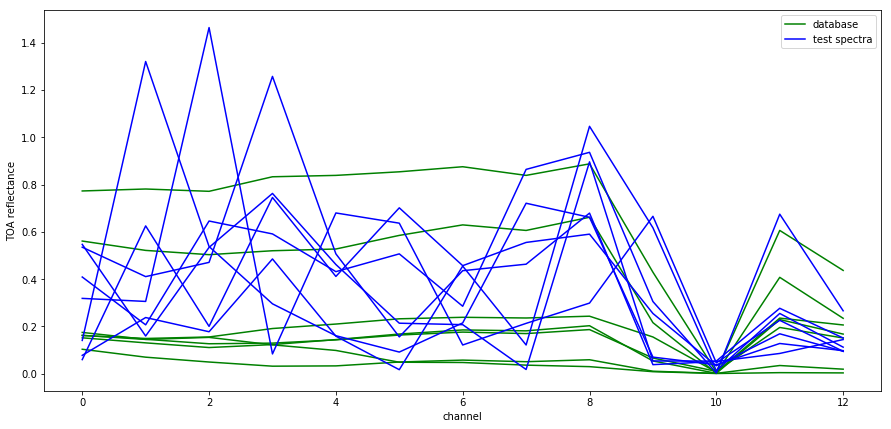

In [13]:
figure(figsize=(15,7))
_ = plot(np.transpose(ds[sample(range(ds.shape[0]),1),:]),"g",label="database")
_ = plot(np.transpose(ds[sample(range(ds.shape[0]),6),:]),"g")
_ = plot(np.transpose(ds_rnd[sample(range(ds_rnd.shape[0]),1),:]),"b",label="test spectra")
_ = plot(np.transpose(ds_rnd[sample(range(ds_rnd.shape[0]),6),:]),"b")
xlabel("channel")
ylabel("TOA reflectance")
legend()

In [14]:
ds_rnd = np.abs(np.transpose(np.vstack([np.random.normal(loc=1*mn,scale=1*sd,size=400000) for mn,sd in 
                                        zip(np.mean(np.array(ds,dtype=np.float),axis=0),np.std(np.array(ds,dtype=np.float),axis=0))])))
XX_nodata = mk_clf(ds_rnd)
XX_data = mk_clf(np.array(ds[:,:],dtype=np.float32))

In [15]:
if False:  # remove clear to test novelty detector
    ds_rnd = np.abs(np.transpose(np.vstack([np.random.normal(loc=1*mn,scale=1*sd,size=400000) for mn,sd in 
                                        zip(np.mean(np.array(ds[ds_y != 10,:],dtype=np.float),axis=0),np.std(np.array(ds[ds_y != 10,:],dtype=np.float),axis=0))])))
    XX_nodata = mk_clf(ds_rnd)
    XX_data = mk_clf(np.array(ds[ds_y != 10,:],dtype=np.float32))

In [16]:
XX_nodata.shape,XX_data.shape

((400000, 5), (3028733, 5))

In [17]:
XX = np.vstack((XX_nodata,XX_data))
YY = np.hstack((-1*np.ones(XX_nodata.shape[0]),1*np.ones(XX_data.shape[0])))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(XX, YY, test_size=0.8, random_state=42)

In [19]:
opts = {"n_estimators":10,"max_depth":10,"random_state":42}
nv = RandomForestClassifier(**opts)
nv.fit(X=X_train,y=y_train)


t0 = time()
pr = nv.predict(X_test)
t1 = time()

tt = (t1-t0) / X_test.shape[0]*5000**2 / 60

accuracy_score(y_test,nv.predict(X_test)),tt

(0.97749497172243249, 0.6941363549095356)

In [20]:
output_path = "/home/gts2/notebooks/cld_mask_dev/"
fn = "noclear_novelty_detector_%s." % (clf_suffix.replace("(","").replace(")","").replace(",","_"))
out_fn = path.join(output_path,fn)
print(out_fn)

/home/gts2/notebooks/cld_mask_dev/noclear_novelty_detector_channel2_difference9_0_index10_1_channel12_index1_8.


In [21]:
import h5py
from os import path
import pickle
import json

#save as h5 file
h5f = h5py.File(out_fn + "h5","w")
h5f.create_dataset(name='xx',shape=XX.shape,dtype=np.float16,data=np.array(XX,dtype=np.float16))
h5f.create_dataset(name='yy',shape=YY.shape,dtype=np.float16,data=np.array(YY,dtype=np.float16))
h5f.attrs["clf"] = json.dumps({"id":mk_clf.classifiers_id,"fk":mk_clf.classifiers_fk})
for k,v in opts.items():
    h5f["xx"].attrs[k] = v
h5f.close()

# save as pickle
with open(out_fn + "pkl","wb") as fl:
    pickle.dump(nv,fl)
    pickle.dump({"id":mk_clf.classifiers_id,"fk":mk_clf.classifiers_fk},fl)

In [22]:
# retrain from h5 file
h5f = h5py.File(out_fn + "h5","r")

nv = RandomForestClassifier(**dict(h5f["xx"].attrs.items()))
nv.fit(X=h5f["xx"],y=h5f["yy"])
bf = json.loads(h5f.attrs["clf"])

with open(out_fn + "retrain.pkl","wb") as fl:
    pickle.dump(nv,fl)
    pickle.dump({"id": [tuple(ids) for ids in bf["id"]],"fk":[str(ids) for ids in bf["fk"]]},fl)
    
h5f.close() 

# Fit Classifier

In [23]:
clf = ClassicalBayesianFit(fit_method="chosen_one",mk_clf=ToClassifierDef(clf_functions=get_clf_functions(),
        classifiers_id=[(2,), (9, 0), (10, 1), (12,), (1, 8)],
        classifiers_fk=['channel', 'difference', 'index', 'channel', 'index']))

In [24]:
clf.set(xx=clf_data["XX_train"],yy=clf_data["YY_train"],smooth=0.2,n_bins=25)

0.99231257353621616

In [25]:
print((__test__(clf,xx=clf_data["XX_test"],yy=clf_data["YY_test"]),
       __test__(clf,xx=clf_data["XX_train"],yy=clf_data["YY_train"])))
for cl in [10,20,30,40,50,60]:
    print(cl,class_ids[cl],np.sum(clf.predict(clf_data["XX_test"][clf_data["YY_test"]==cl,:]) == cl) / (np.sum(clf_data["YY_test"]==cl)))

(0.99042588312974578, 0.99243250496413393)
10 Clear 0.980318650422
20 Water 1.0
30 Shadow 0.986486486486
40 Cirrus 0.991902834008
50 Cloud 0.997987927565
60 Snow 0.997619047619


In [26]:
print(fn_out)
write_classical_Bayesian_to_hdf5_file(
    clf=clf,filename=fn_out,class_names=class_names,
    mask_legend=mask_legend,clf_to_col=clf_to_col,band_names=band_names)
data = read_classical_Bayesian_from_hdf5_file(fn_out)
print(data.keys())

/home/gts2/data/aux_data/cld_mask/cld_mask_S2_classi_20170413_v20170413_11:19:40.h5
dict_keys(['clf_to_col', 'mask_legend', 'kwargs_cB', 'kwargs_mk_clf'])


# Modify Data

In [ ]:
xx,yy = np.copy(clf_data["XX_train"]), np.copy(clf_data["YY_train"])
XX,YY = np.copy(clf_data["XX_test"]), np.copy(clf_data["YY_test"])

In [ ]:
def sel(xx,yy):
    
    ids = (yy == 30) & np.logical_and.reduce((xx[:,0] < 0.2,xx[:,11] < 0.045,xx[:,12] < 0.045)) # xx[:,7] < 0.05
    
    yys = np.copy(yy)
    yys[yys == 30] = 10
    yys[ids] = 30
    
    return yys

In [ ]:
dd = 10
vp = violinplot(xx[yy == 30,:][::dd,:],positions=np.arange(xx.shape[1]),showmeans=True, showextrema=False, showmedians=False,vert=True)
for pc in vp['bodies']:
    pc.set_facecolor('0.6')
    pc.set_edgecolor("None")
    
vp = violinplot(xx[sel(xx,yy) == 30,:][::dd,:],positions=np.arange(xx.shape[1]),showmeans=True, showextrema=False, showmedians=False,vert=True)
for pc in vp['bodies']:
    pc.set_facecolor('red')
    pc.set_edgecolor("None")   
       
    
ylim(0.0,0.3) 
xlim(-1,13)

In [ ]:
yys = sel(xx,yy)
YYs = sel(XX,YY)

In [ ]:
def pp(yy):
    return {class_id:np.sum(yy==class_id) for class_id in set(yy)}

In [ ]:
print(pp(yy))
print(pp(yys))

print(pp(YY))
print(pp(YYs))

In [ ]:
clf = ClassicalBayesianFit(fit_method="chosen_one",mk_clf=ToClassifierDef(clf_functions=get_clf_functions(),
        classifiers_id=[(2,), (9, 0), (10, 1), (12,), (1, 8)],
        classifiers_fk=['channel', 'difference', 'index', 'channel', 'index']))
clf.set(xx=xx,yy=yys,smooth=0.2,n_bins=25)

In [ ]:
print((__test__(clf,xx=xx,yy=yys),
       __test__(clf,xx=XX,yy=YYs))
     )
for cl in [10,20,30,40,50,60]:
    print(cl,class_ids[cl],np.sum(clf.predict(xx[yys==cl,:]) == cl) / (np.sum(yys==cl)))

In [ ]:
fn_out_s = fn_out.replace(suffix,"%s_mod_shadow" % suffix)
print(fn_out_s)

write_classical_Bayesian_to_hdf5_file(
    clf=clf,filename=fn_out_s,class_names=class_names,
    mask_legend=mask_legend,clf_to_col=clf_to_col,band_names=band_names)
data = read_classical_Bayesian_from_hdf5_file(fn_out_s)
print(data.keys())

# Programatic Modify Data

In [ ]:
from os.path import exists
from itertools import product

In [ ]:
xx,yy = np.copy(clf_data["XX_train"]), np.copy(clf_data["YY_train"])
XX,YY = np.copy(clf_data["XX_test"]), np.copy(clf_data["YY_test"])

In [ ]:
def applay_change(changes,id_change=30,id_default=10):
    
    suffix_ch = "".join(["_%i%s%.3f" % (c["ch"],{np.less:"l"}[c["f"]],c["y"]) for c in changes])
    #print(suffix_ch)
    suffix_ch = "_id%s_id%s" % (id_change, id_default) + suffix_ch
    #print(suffix_ch)
    #print(fn_out)
    fn_out_s = fn_out.replace(suffix,"%s%s" % (suffix,suffix_ch))
    print(fn_out_s)
    #return fn_out_s

    if exists(fn_out_s):
        return fn_out_s

    print("%s --> %s" % (id_change,id_default))
    def sel(xx,yy):   
        yys = np.copy(yy)
        yys[yys == id_change] = id_default    
        ids = (yy == id_change) & np.logical_and.reduce(tuple([c["f"](xx[:,c["ch"]],c["y"]) for c in changes]))    
        yys[ids] = id_change    
        return yys

    yys = sel(xx,yy)
    YYs = sel(XX,YY)

    
    fig = figure(figsize=(10,5))
    dd = 10
    vp = violinplot(xx[yy == id_change,:][::dd,:],positions=np.arange(xx.shape[1]),showmeans=True, showextrema=False, showmedians=False,vert=True)
    for pc in vp['bodies']:
        pc.set_facecolor('0.6')
        pc.set_edgecolor("None")

    vp = violinplot(xx[yys == id_change,:][::dd,:],positions=np.arange(xx.shape[1]),showmeans=True, showextrema=False, showmedians=False,vert=True)
    for pc in vp['bodies']:
        pc.set_facecolor('red')
        pc.set_edgecolor("None")   
        
    
    #hlines([c["y"] for c in changes],-1,13,linestyles="dotted")        
    for c in changes:
        hlines(c["y"],c["ch"]-0.25,c["ch"]+0.25,linestyles="solid",colors="b")


    ylim(0.0,0.5) 
    xlim(-1,13)  
    
    savefig(fn_out_s.replace(".h5","_selection.jpg"))
    fig.clf()
                  
    clf = ClassicalBayesianFit(fit_method="chosen_one",mk_clf=ToClassifierDef(clf_functions=get_clf_functions(),
            classifiers_id=[(2,), (9, 0), (10, 1), (12,), (1, 8)],
            classifiers_fk=['channel', 'difference', 'index', 'channel', 'index']))
    clf.set(xx=xx,yy=yys,smooth=0.2,n_bins=25)

    print((__test__(clf,xx=xx,yy=yys),
           __test__(clf,xx=XX,yy=YYs))
         )
    for cl in [10,20,30,40,50,60]:
        print(cl,class_ids[cl],np.sum(clf.predict(xx[yys==cl,:]) == cl) / (np.sum(yys==cl)))


    write_classical_Bayesian_to_hdf5_file(
        clf=clf,filename=fn_out_s,class_names=class_names,
        mask_legend=mask_legend,clf_to_col=clf_to_col,band_names=band_names)
    data = read_classical_Bayesian_from_hdf5_file(fn_out_s)
    print(data.keys())  
    
    return fn_out_s

In [ ]:
from S2MSI import S2Image, CloudMask
from glob import glob
from S2SCAPEM.options import get_options
from os.path import basename
import pickle
with open("./options.pkl","rb") as fl:
    options, = pickle.load(fl)
import os

In [ ]:
#### The following should be sufficient to cut cloud mask spetra
cld_mask_file = applay_change(changes=[{"ch":8,"f":np.less,"y":0.13},
                                            {"ch":11,"f":np.less,"y":0.06},
                                           {"ch":12,"f":np.less,"y":0.04}],
                                       id_change=30,id_default=10    )  
####

In [ ]:
cld_mask_file=""
options = get_options(target="/home/gts2/notebooks/gts2_options_ESA_aerosol_ECMWF_v0.10_HD_v1.0.json")

In [ ]:
#s2img = S2Image(logger=None,driver="gdal_JP2KAK",S2_MSI_granule_path="/home/gts2/data/S2_AC_FS_2/35V/LJ/2016/S2A_OPER_PRD_MSIL1C_PDMC_20160330T142613_R122_V20160327T100012_20160327T100012.SAFE/GRANULE/S2A_OPER_MSI_L1C_TL_SGS__20160327T140224_A003980_T35VLJ_N02.01/")
#s2img = S2Image(logger=None,driver="gdal_JP2KAK",S2_MSI_granule_path="/home/gts2/data/S2_AC_FS_2/32T/MR/2016/S2A_OPER_PRD_MSIL1C_PDMC_20160624T193752_R108_V20160624T103721_20160624T103721.SAFE/GRANULE/S2A_OPER_MSI_L1C_TL_SGS__20160624T173213_A005253_T32TMR_N02.04")
#s2img = S2Image(logger=None,driver="gdal_JP2KAK",,S2_MSI_granule_path="/home/gts2/data/S2_AC_FS_2/32T/MR/2016/S2A_MSIL1C_20161228T102432_N0204_R065_T32TMR_20161228T102428.SAFE/GRANULE/L1C_T32TMR_A007927_20161228T102428")
s2img = S2Image(logger=None,driver="gdal_JP2KAK",S2_MSI_granule_path="/home/gts2/data/S2_AC_FS_2/35V/LJ/2016/S2A_OPER_PRD_MSIL1C_PDMC_20160901T191510_R079_V20160831T095032_20160831T095217.SAFE/GRANULE/S2A_OPER_MSI_L1C_TL_MPS__20160831T133451_A006225_T35VLJ_N02.04")
#s2img = S2Image(logger=None,driver="gdal_JP2KAK",S2_MSI_granule_path="/home/gts2/data/S2_AC_FS_2/32T/NR/2016/S2A_OPER_PRD_MSIL1C_PDMC_20160323T192233_R065_V20160323T102143_20160323T102143.SAFE/GRANULE/S2A_OPER_MSI_L1C_TL_SGS__20160323T160631_A003923_T32TNR_N02.01")
#s2img = S2Image(logger=None,driver="gdal_JP2KAK",S2_MSI_granule_path="/home/gts2/data/S2_AC_FS_2/36R/XV/2016/S2A_OPER_PRD_MSIL1C_PDMC_20161023T185504_R121_V20161023T082012_20161023T082012.SAFE/GRANULE/S2A_OPER_MSI_L1C_TL_SGS__20161023T135300_A006982_T36RXV_N02.04")

In [ ]:
mask_clouds = {}
fn_out = ("/home/gts2/data/aux_data/cld_mask/cld_mask_" + path.basename(fn_mc)).replace(".dill", ".h5")
fn_out = fn_out.replace("/home/gts2/data/aux_data/cld_mask","/home/gts2/notebooks/cld_mask")

In [ ]:
if True:
    #############
    #Attention! The band numbers start with 0 and band 8 is actually band 8a
    ###########
    #"""
    cld_mask_file = applay_change(changes=[{"ch":6,"f":np.less,"y":0.8}],
                                  id_change=30,id_default=10    )
    fn_out=cld_mask_file 
    """
    cld_mask_file = applay_change(changes=[{"ch":8,"f":np.less,"y":0.15},
                                            {"ch":11,"f":np.less,"y":0.09},
                                           {"ch":12,"f":np.less,"y":0.07}],
                                  id_change=30,id_default=10    )  
    """
    bn = basename(cld_mask_file)
    if bn not in mask_clouds:
        print(bn)        
        CldMsk = CloudMask(logger=None, persistence_file=cld_mask_file,
                           processing_tiles=options["cld_mask"]["processing_tiles"])

        mask_clouds[bn] = CldMsk(S2_img=s2img, target_resolution=options["cld_mask"]["target_resolution"],
                                 majority_filter_options=options["cld_mask"]["majority_mask_filter"],
                                 nodata_value=options["cld_mask"]['nodata_value_mask'])  
        #out_name = os.path.join("/home/gts2/notebooks/cld_mask","35VJL_20160327_" + os.path.basename(bn)).replace(".h5",".jpg")
        #out_name = os.path.join("/home/gts2/notebooks/cld_mask","35VJL_20160831_" + os.path.basename(bn)).replace(".h5",".jpg")
        #out_name = os.path.join("/home/gts2/notebooks/cld_mask","32TMR_20160624_" + os.path.basename(bn)).replace(".h5",".jpg")
        #out_name = os.path.join("/home/gts2/notebooks/cld_mask","32TMR_20161228_" + os.path.basename(bn)).replace(".h5",".jpg")
        #out_name = os.path.join("/home/gts2/notebooks/cld_mask","32TNR_20160323_" + os.path.basename(bn)).replace(".h5",".jpg")
        #out_name = os.path.join("/home/gts2/notebooks/cld_mask","36RXV_20161023_" + os.path.basename(bn)).replace(".h5",".jpg")
        
        #out_name = os.path.join("/home/gts2/notebooks/cld_mask","35VJL_20160327_cld_mask_S2_classi_20160330_original.jpg")
        out_name = os.path.join("/home/gts2/notebooks/cld_mask","35VJL_20160831_cld_mask_S2_classi_20160330_original.jpg")
        #out_name = os.path.join("/home/gts2/notebooks/cld_mask","32TMR_20160624_cld_mask_S2_classi_20160330_original.jpg")
        #out_name = os.path.join("/home/gts2/notebooks/cld_mask","32TMR_20161228_cld_mask_S2_classi_20160330_original.jpg")
        #out_name = os.path.join("/home/gts2/notebooks/cld_mask","32TNR_20160323_cld_mask_S2_classi_20160330_original.jpg")

        print(out_name)
        mask_clouds[bn].export_mask_rgb(fn_img=out_name,rgb_img=mask_clouds[bn].mask_rgb_array()) 

In [ ]:
# Test majority_mask_filter
from S2MSI.Tools import majority_mask_filter
CldMsk = CloudMask(logger=None, persistence_file="/home/gts2/data/aux_data/cld_mask/cld_mask_S2_classi_20170330_id30_id10_8l0.130_11l0.045_12l0.025.h5",
                           processing_tiles=options["cld_mask"]["processing_tiles"])

ccmm = CldMsk(S2_img=s2img, target_resolution=options["cld_mask"]["target_resolution"],
                                 majority_filter_options=options["cld_mask"]["majority_mask_filter"],
                                 nodata_value=options["cld_mask"]['nodata_value_mask'])  


In [ ]:
%matplotlib notebook
import pylab as plt

In [ ]:
ffccmm =majority_mask_filter(ccmm.mask_array, majority_width=5, block_replace=True, block_replace_params=((50, 5),(30,5)), nodata_value=255)
ffccmm2=majority_mask_filter(ccmm.mask_array, majority_width=5, block_replace=True, block_replace_params=((50, 5),), nodata_value=255)

In [ ]:
plt.imshow(ffccmm, interpolation="none", vmin=0, vmax=60)

In [ ]:
plt.imshow(ffccmm2, interpolation="none", vmin=0, vmax=60)

In [ ]:
import pickle
with open("/home/gts2/notebooks/cld_mask_tmp.pkl", "wb") as f:
    pickle.dump(ccmm.mask_array,f)

In [ ]:
if False:
    for ii in np.linspace(0.1,0.2,5):
        cld_mask_file = applay_change(changes=[{"ch":8,"f":np.less,"y":ii}],
                      id_change=30,id_default=10
                 )
       
        
        bn = basename(cld_mask_file)
        if bn not in mask_clouds:
            print(bn)        
            CldMsk = CloudMask(logger=None, persistence_file=cld_mask_file,
                               processing_tiles=options["cld_mask"]["processing_tiles"])

            mask_clouds[bn] = CldMsk(S2_img=s2img, target_resolution=options["cld_mask"]["target_resolution"],
                                     majority_filter_options=options["cld_mask"]["majority_mask_filter"],
                                     nodata_value=options["cld_mask"]['nodata_value_mask'])        
            print(bn.replace(".h5",".jpg"))
            mask_clouds[bn].export_mask_rgb(fn_img=bn.replace(".h5",".jpg"),rgb_img=mask_clouds[bn].mask_rgb_array())

In [ ]:
bn.replace(".h5",".jpg")

In [ ]:
for i8,i11,i12 in product(np.linspace(0.12,0.18,5), # i8
                          np.linspace(0.035,0.055,5),  # i11
                          np.linspace(0.02,0.03,5)): # i12
    cld_mask_file = applay_change(changes=[{"ch":8,"f":np.less,"y":i8},
                                           {"ch":11,"f":np.less,"y":i11},
                                           {"ch":12,"f":np.less,"y":i12}],
                                  id_change=30,id_default=10
             )
    
    bn = basename(cld_mask_file)
    if bn not in mask_clouds:
        print(bn)        
        CldMsk = CloudMask(logger=None, persistence_file=cld_mask_file,
                           processing_tiles=options["cld_mask"]["processing_tiles"])

        mask_clouds[bn] = CldMsk(S2_img=s2img, target_resolution=options["cld_mask"]["target_resolution"],
                                 majority_filter_options=options["cld_mask"]["majority_mask_filter"],
                                 nodata_value=options["cld_mask"]['nodata_value_mask'])  
        print(bn.replace(".h5",".jpg"))
        mask_clouds[bn].export_mask_rgb(fn_img=bn.replace(".h5",".jpg"),rgb_img=mask_clouds[bn].mask_rgb_array())    

In [ ]:
len(mask_clouds.keys())